In [64]:
import pandas as pd
import numpy as np

In [68]:
df_games = pd.read_csv("nba-games/games.csv")
df_games_details = pd.read_csv("nba-games/games_details.csv")

/var/folders/fr/6hz0nwpn7pn7qyy7pdgps2j40000gn/T/ipykernel_39723/2125918360.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_games_details = pd.read_csv("nba-games/games_details.csv")


In [69]:
def convert_min_to_float(min_str):
    try:
        minutes, seconds = map(int, str(min_str).split(":"))
        return minutes + seconds / 60
    except:
        return 0

def aggregate_player_stats(df_games_details):
    df_games_details['MIN_float'] = df_games_details['MIN'].astype(str).apply(convert_min_to_float)

    team_game_stats = df_games_details.groupby(['GAME_ID', 'TEAM_ID']).agg({
        'FGM': 'sum',
        'FGA': 'sum',
        'FG3M': 'sum',
        'FG3A': 'sum',
        'FTM': 'sum',
        'FTA': 'sum',
        'AST':'sum',
        'OREB': 'sum',
        'DREB': 'sum',
        'STL': 'sum',
        'BLK': 'sum',
        'TO': 'sum',
        'PF': 'sum',
        'PTS':'sum'
    }).reset_index()

    team_game_stats['FG3_PCT'] = team_game_stats['FG3M'] / team_game_stats['FG3A']
    team_game_stats['FG_PCT'] = team_game_stats['FGM'] / team_game_stats['FGA']
    team_game_stats['FT_PCT'] = team_game_stats['FTM'] / team_game_stats['FTA']

    return team_game_stats

df_games_details = aggregate_player_stats(df_games_details)

In [70]:
df_games_cleaned = df_games.drop(columns=['GAME_STATUS_TEXT', 'TEAM_ID_home', 'TEAM_ID_away'], errors='ignore')
df_games_cleaned = df_games_cleaned.rename(columns={
    'HOME_TEAM_ID': 'TEAM_ID_HOME',
    'VISITOR_TEAM_ID': 'TEAM_ID_AWAY'
})

df_games_cleaned.columns = [col.upper() for col in df_games_cleaned.columns]
df_games_cleaned = df_games_cleaned[df_games_cleaned['SEASON'] != 2022]
df_games_cleaned = df_games_cleaned[df_games_cleaned['SEASON'] != 2003]

columns_to_drop = [
    'PTS_HOME', 'FG_PCT_HOME', 'FT_PCT_HOME', 'FG3_PCT_HOME', 'AST_HOME',
    'REB_HOME', 'PTS_AWAY', 'FG_PCT_AWAY', 'FT_PCT_AWAY', 'FG3_PCT_AWAY',
    'AST_AWAY', 'REB_AWAY'
]

games_cleaned = df_games_cleaned.drop(columns=columns_to_drop)

In [71]:
games_cleaned.columns

Index(['GAME_DATE_EST', 'GAME_ID', 'TEAM_ID_HOME', 'TEAM_ID_AWAY', 'SEASON',
       'HOME_TEAM_WINS'],
      dtype='object')

In [72]:
home_stats = df_games_details.rename(columns=lambda col: col + '_HOME' if col not in ['GAME_ID', 'TEAM_ID'] else col)
home_stats = home_stats.rename(columns={'TEAM_ID': 'TEAM_ID_HOME'})
df_games_merged = games_cleaned.merge(home_stats, on=['GAME_ID', 'TEAM_ID_HOME'], how='left')

away_stats = df_games_details.rename(columns=lambda col: col + '_AWAY' if col not in ['GAME_ID', 'TEAM_ID'] else col)
away_stats = away_stats.rename(columns={'TEAM_ID': 'TEAM_ID_AWAY'})
df_games_merged = df_games_merged.merge(away_stats, on=['GAME_ID', 'TEAM_ID_AWAY'], how='left')

df_games_merged = df_games_merged.sort_values(by='GAME_DATE_EST')
df_games_merged = df_games_merged.dropna()

In [73]:
#function to add four factors
def add_four_factors(df):
    df = df.copy()  

    # Possessions
    df['POSSESSIONS_HOME'] = (df['FGA_HOME'] - df['OREB_HOME'] + df['TO_HOME'] + 0.44 * df['FTA_HOME'])
    df['POSSESSIONS_AWAY'] = (df['FGA_AWAY'] - df['OREB_AWAY'] + df['TO_AWAY'] + 0.44 * df['FTA_AWAY'])

    # Effective Field Goal %
    df['eFG%_HOME'] = (df['FGM_HOME'] + 0.5 * df['FG3M_HOME']) / df['FGA_HOME']
    df['eFG%_AWAY'] = (df['FGM_AWAY'] + 0.5 * df['FG3M_AWAY']) / df['FGA_AWAY']

    # Turnover Percentage
    df['TO%_HOME'] = df['TO_HOME'] / df['POSSESSIONS_HOME']
    df['TO%_AWAY'] = df['TO_AWAY'] / df['POSSESSIONS_AWAY']

    # Offensive Rebound Percentage
    df['OR%_HOME'] = df['OREB_HOME'] / (df['OREB_HOME'] + df['DREB_AWAY'])
    df['OR%_AWAY'] = df['OREB_AWAY'] / (df['OREB_AWAY'] + df['DREB_HOME'])

    # Free Throw Rate
    df['FTR_HOME'] = df['FTA_HOME'] / df['FGA_HOME']
    df['FTR_AWAY'] = df['FTA_AWAY'] / df['FGA_AWAY']

    return df

df_full = add_four_factors(df_games_merged)

In [74]:
df_full.to_csv("full_games.csv", index=False)

In [ ]:
import numpy as np
df = pd.read_csv("full_games.csv")
df['GAME_DATE_EST'] = pd.to_datetime(df_full['GAME_DATE_EST'])
df = df.sort_values(by='GAME_DATE_EST').reset_index(drop=True)

initial_elo = 1500
elo_ratings = {}
k_base = 20
carryover_season_weight = 0.75
carryover_baseline = 1505

elo_cols = [
    'ELO_HOME_BEFORE', 'ELO_AWAY_BEFORE',
    'ELO_HOME_AFTER', 'ELO_AWAY_AFTER',
    'ELO_EXPECTED_HOME', 'ELO_EXPECTED_AWAY',
    'ELO_MARGIN_MULTIPLIER'
]

for col in elo_cols:
    df[col] = np.nan

last_season = None

for idx, row in df.iterrows():
    season = row['SEASON']
    home = row['TEAM_ID_HOME']
    away = row['TEAM_ID_AWAY']
    pts_home = row['PTS_HOME']
    pts_away = row['PTS_AWAY']

    if season != last_season:
        for team in elo_ratings:
            elo_ratings[team] = carryover_season_weight * elo_ratings[team] + (1 - carryover_season_weight) * carryover_baseline
        last_season = season

    elo_home = elo_ratings.get(home, initial_elo)
    elo_away = elo_ratings.get(away, initial_elo)

    expected_home = 1 / (1 + 10 ** ((elo_away - elo_home) / 400))
    expected_away = 1 - expected_home

    outcome_home = 1 if pts_home > pts_away else 0
    outcome_away = 1 - outcome_home

    margin = abs(pts_home - pts_away)
    elo_diff = abs(elo_home - elo_away)

    if pts_home > pts_away and elo_home < elo_away:
    
        D = -abs(elo_home - elo_away)
    elif pts_away > pts_home and elo_away < elo_home:
    
        D = -abs(elo_home - elo_away)
    elif pts_home > pts_away and elo_home >= elo_away:
    
        D = abs(elo_home - elo_away)
    elif pts_away > pts_home and elo_away >= elo_home:
    
        D = abs(elo_home - elo_away)
    else:
    
        D = 0


    
    mov_multiplier = ((margin + 3) ** 0.8) / (7.5 + 0.006 * D)
   
    change_home = k_base * mov_multiplier * (outcome_home - expected_home)
    change_away = k_base * mov_multiplier * (outcome_away - expected_away)

    elo_ratings[home] = elo_home + change_home
    elo_ratings[away] = elo_away + change_away

    df.at[idx, 'ELO_HOME_BEFORE'] = elo_home
    df.at[idx, 'ELO_AWAY_BEFORE'] = elo_away
    df.at[idx, 'ELO_HOME_AFTER'] = elo_ratings[home]
    df.at[idx, 'ELO_AWAY_AFTER'] = elo_ratings[away]
    df.at[idx, 'ELO_EXPECTED_HOME'] = expected_home
    df.at[idx, 'ELO_EXPECTED_AWAY'] = expected_away
    df.at[idx, 'ELO_MARGIN_MULTIPLIER'] = mov_multiplier

In [99]:
df.to_csv("full_games_elo.csv", index=False)

In [100]:
df['GAME_DATE_EST'] = pd.to_datetime(df['GAME_DATE_EST'])

shared_stats = [
    'PTS', 'FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST',
    'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA',
    'OREB', 'DREB', 'STL', 'BLK', 'TO', 'PF',
    'POSSESSIONS', 'eFG%', 'TO%', 'OR%', 'FTR'
]

def compute_rolling_features(df, stat_cols, x):
    def get_team_games_before_date(df_all, team_id, date):
        return df_all[
            ((df_all['TEAM_ID_HOME'] == team_id) | (df_all['TEAM_ID_AWAY'] == team_id)) &
            (df_all['GAME_DATE_EST'] < date)
        ].sort_values(by='GAME_DATE_EST', ascending=False)

    def get_team_stats_from_game(game_row, team_id, stat_cols):
        if game_row['TEAM_ID_HOME'] == team_id:
            return game_row[[f"{stat}_HOME" for stat in stat_cols]].values
        else:
            return game_row[[f"{stat}_AWAY" for stat in stat_cols]].values

    def get_avg_stats_last_x_games(df_all, team_id, date, x, stat_cols):
        past_games = get_team_games_before_date(df_all, team_id, date)
        if past_games.empty:
            return {f"{stat}_AVG_LAST_{x}": np.nan for stat in stat_cols}

        stats_matrix = []
        for _, game_row in past_games.head(x).iterrows():
            stats = get_team_stats_from_game(game_row, team_id, stat_cols)
            stats_matrix.append(stats)

        stats_df = pd.DataFrame(stats_matrix, columns=stat_cols)
        return {f"{stat}_AVG_LAST_{x}": stats_df[stat].mean() for stat in stat_cols}

    home_avg_stats = df.apply(
        lambda row: get_avg_stats_last_x_games(df, row['TEAM_ID_HOME'], row['GAME_DATE_EST'], x, stat_cols),
        axis=1
    )

    away_avg_stats = df.apply(
        lambda row: get_avg_stats_last_x_games(df, row['TEAM_ID_AWAY'], row['GAME_DATE_EST'], x, stat_cols),
        axis=1
    )

    home_df = pd.DataFrame(home_avg_stats.tolist()).add_prefix('HOME_')
    away_df = pd.DataFrame(away_avg_stats.tolist()).add_prefix('AWAY_')

    df_with_rolling = pd.concat([df.reset_index(drop=True), home_df, away_df], axis=1)
    df_with_rolling = df_with_rolling.dropna(subset=[col for col in df_with_rolling.columns if f'_AVG_LAST_{x}' in col])

    return df_with_rolling

for x in range(4, 21):
    print(f"Generating rolling averages for last {x} games...")
    df_rolled = compute_rolling_features(df, shared_stats, x)
    df_rolled.to_csv(f"df_elo_{x}.csv", index=False)
    print(f"Saved to df_full_{x}.csv")

Generating rolling averages for last 4 games...
Saved to df_full_4.csv
Generating rolling averages for last 5 games...
Saved to df_full_5.csv
Generating rolling averages for last 6 games...
Saved to df_full_6.csv
Generating rolling averages for last 7 games...
Saved to df_full_7.csv
Generating rolling averages for last 8 games...
Saved to df_full_8.csv
Generating rolling averages for last 9 games...
Saved to df_full_9.csv
Generating rolling averages for last 10 games...
Saved to df_full_10.csv
Generating rolling averages for last 11 games...
Saved to df_full_11.csv
Generating rolling averages for last 12 games...
Saved to df_full_12.csv
Generating rolling averages for last 13 games...
Saved to df_full_13.csv
Generating rolling averages for last 14 games...
Saved to df_full_14.csv
Generating rolling averages for last 15 games...
Saved to df_full_15.csv
Generating rolling averages for last 16 games...
Saved to df_full_16.csv
Generating rolling averages for last 17 games...
Saved to df_fu

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("full_games_elo.csv")
df['GAME_DATE_EST'] = pd.to_datetime(df['GAME_DATE_EST'])

shared_stats = [
    'PTS', 'FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST',
    'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA',
    'OREB', 'DREB', 'STL', 'BLK', 'TO', 'PF',
    'POSSESSIONS', 'eFG%', 'TO%', 'OR%', 'FTR'
]

df_cumulative_all = pd.DataFrame()

for season in sorted(df['SEASON'].unique()):
    df_season = df[df['SEASON'] == season].sort_values(by='GAME_DATE_EST').copy()
    rows = []

    for idx, row in df_season.iterrows():
        home_id = row['TEAM_ID_HOME']
        away_id = row['TEAM_ID_AWAY']
        game_date = row['GAME_DATE_EST']

        home_past = df_season[
            ((df_season['TEAM_ID_HOME'] == home_id) | (df_season['TEAM_ID_AWAY'] == home_id)) &
            (df_season['GAME_DATE_EST'] < game_date)
        ]

        away_past = df_season[
            ((df_season['TEAM_ID_HOME'] == away_id) | (df_season['TEAM_ID_AWAY'] == away_id)) &
            (df_season['GAME_DATE_EST'] < game_date)
        ]

        def get_team_stat_matrix(past_games, team_id, stat_cols):
            matrix = []
            for _, game in past_games.iterrows():
                if game['TEAM_ID_HOME'] == team_id:
                    stats = game[[f"{stat}_HOME" for stat in stat_cols]].values
                else:
                    stats = game[[f"{stat}_AWAY" for stat in stat_cols]].values
                matrix.append(stats)
            return pd.DataFrame(matrix, columns=stat_cols) if matrix else pd.DataFrame(columns=stat_cols)

        home_stats_df = get_team_stat_matrix(home_past, home_id, shared_stats)
        away_stats_df = get_team_stat_matrix(away_past, away_id, shared_stats)

        home_avg = {f"HOME_{stat}_AVG_SEASON": home_stats_df[stat].mean() for stat in shared_stats}
        away_avg = {f"AWAY_{stat}_AVG_SEASON": away_stats_df[stat].mean() for stat in shared_stats}

        row_data = row.to_dict()
        row_data.update(home_avg)
        row_data.update(away_avg)
        rows.append(row_data)

    df_cumulative_all = pd.concat([df_cumulative_all, pd.DataFrame(rows)], ignore_index=True)

rolling_cols = [col for col in df_cumulative_all.columns if '_AVG_SEASON' in col]
df_cumulative_all = df_cumulative_all.dropna(subset=rolling_cols)

output_path = "df_elo_season_averages.csv"
df_cumulative_all.to_csv(output_path, index=False)
output_path


'df_elo_season_averages.csv'

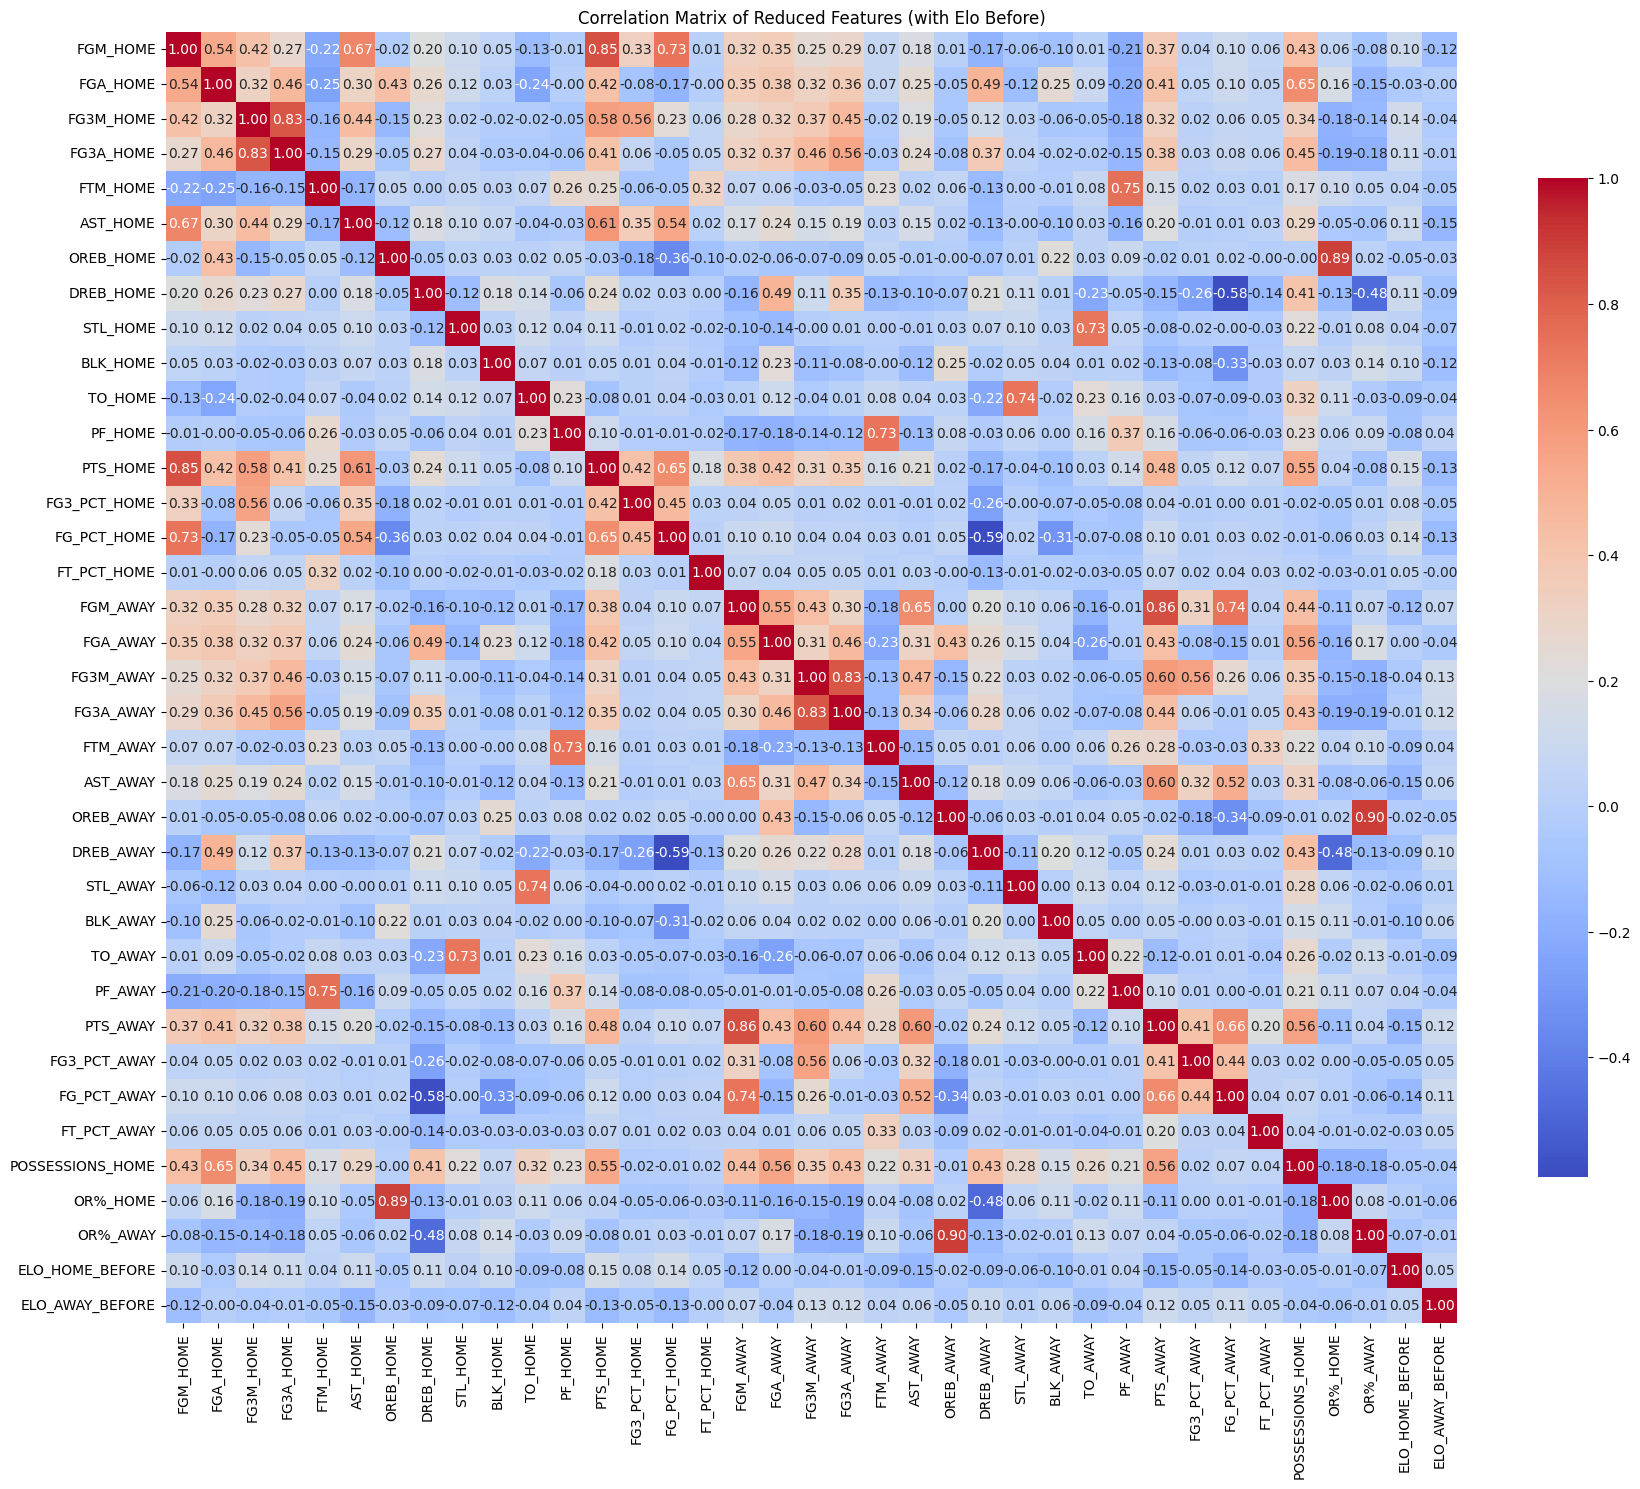

OREB_AWAY - OR%_AWAY: 0.899
OREB_HOME - OR%_HOME: 0.893
FGM_AWAY - PTS_AWAY: 0.857
FGM_HOME - PTS_HOME: 0.848
FG3M_HOME - FG3A_HOME: 0.827
FG3M_AWAY - FG3A_AWAY: 0.827


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "full_games_elo.csv" 
df = pd.read_csv(file_path)

columns_to_drop = [
    'GAME_DATE_EST', 'GAME_ID', 'TEAM_ID_HOME', 'TEAM_ID_AWAY', 'SEASON',
    'ELO_HOME_AFTER', 'ELO_AWAY_AFTER', 'ELO_EXPECTED_HOME',
    'ELO_EXPECTED_AWAY', 'ELO_MARGIN_MULTIPLIER'
]
df = df.drop(columns=columns_to_drop)

target_col = 'HOME_TEAM_WINS'
features_only = df.drop(columns=[target_col])

corr_matrix = features_only.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]

elo_before_cols = ['ELO_HOME_BEFORE', 'ELO_AWAY_BEFORE']
to_drop_final = [col for col in to_drop if col not in elo_before_cols]

reduced_features = features_only.drop(columns=to_drop_final)

final_df = pd.concat([df[target_col], reduced_features], axis=1)

plt.figure(figsize=(18, 15))
sns.heatmap(reduced_features.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.75})
plt.title("Correlation Matrix of Reduced Features (with Elo Before)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

high_corr_pairs = []
for i in range(len(reduced_features.columns)):
    for j in range(i + 1, len(reduced_features.columns)):
        corr_val = reduced_features.corr().iloc[i, j]
        if abs(corr_val) > 0.75:
            high_corr_pairs.append((
                reduced_features.columns[i],
                reduced_features.columns[j],
                round(corr_val, 3)
            ))

high_corr_pairs = sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)
for a, b, val in high_corr_pairs:
    print(f"{a} - {b}: {val}")


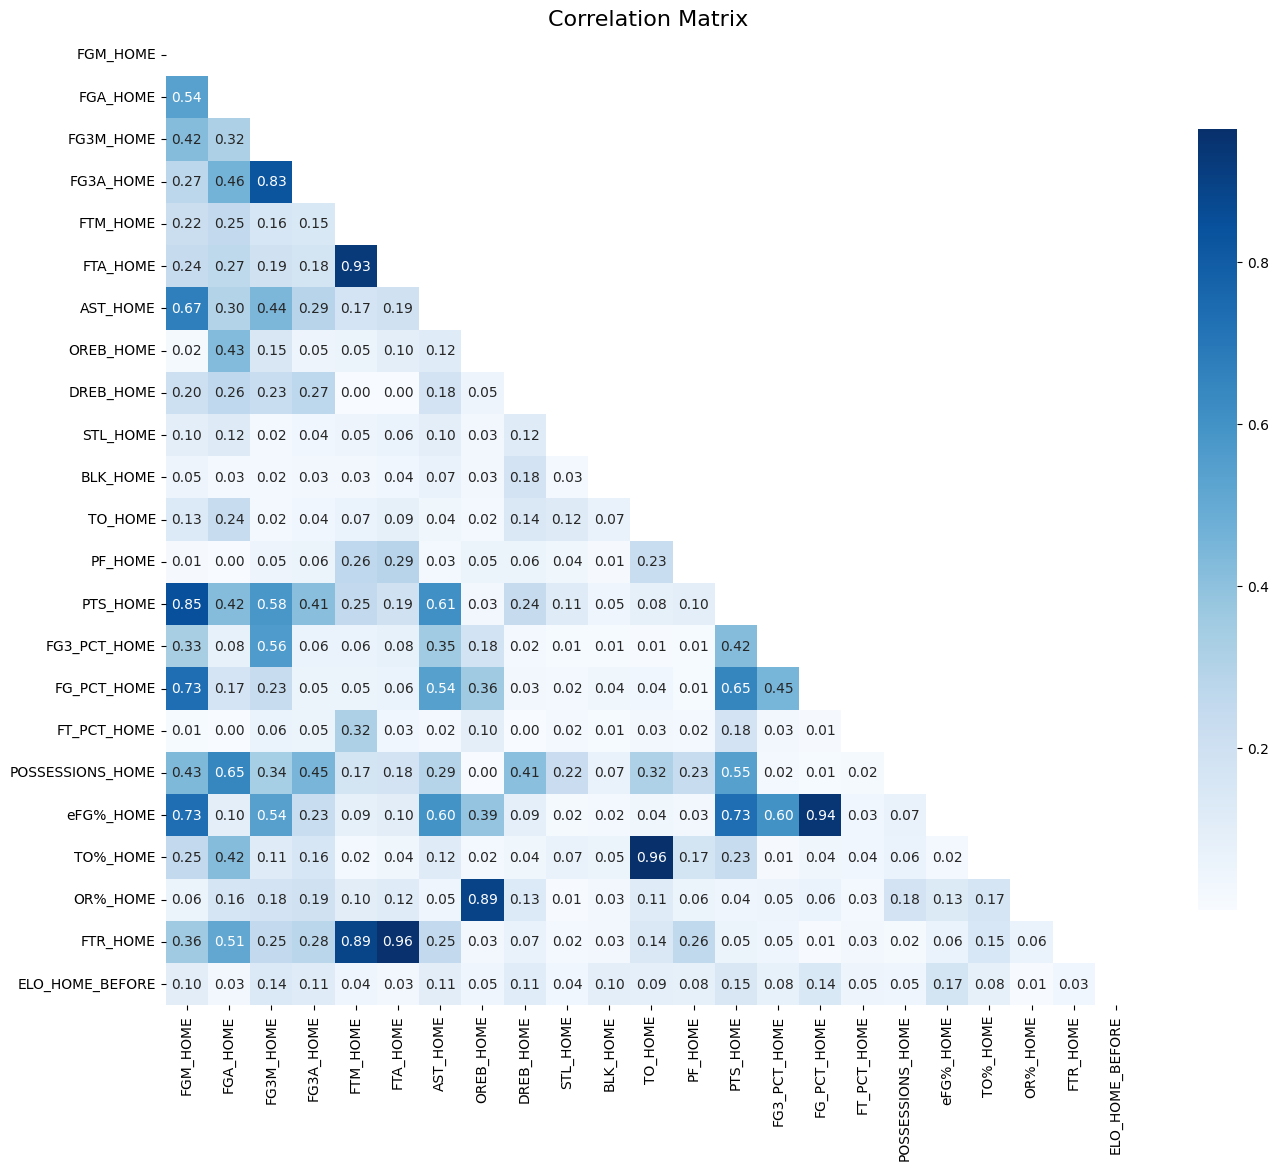


Highly correlated feature pairs (r > 0.80):
FG3A_HOME - FG3M_HOME: 0.827
FTA_HOME - FTM_HOME: 0.928
PTS_HOME - FGM_HOME: 0.848
eFG%_HOME - FG_PCT_HOME: 0.94
TO%_HOME - TO_HOME: 0.964
OR%_HOME - OREB_HOME: 0.893
FTR_HOME - FTM_HOME: 0.89
FTR_HOME - FTA_HOME: 0.958


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "full_games_elo.csv"  
df = pd.read_csv(file_path)

columns_to_drop = [
    'GAME_DATE_EST', 'GAME_ID', 'TEAM_ID_HOME', 'TEAM_ID_AWAY', 'SEASON',
    'ELO_HOME_AFTER', 'ELO_AWAY_AFTER', 'ELO_EXPECTED_HOME',
    'ELO_EXPECTED_AWAY', 'ELO_MARGIN_MULTIPLIER'
]
df = df.drop(columns=columns_to_drop)

home_features = [col for col in df.columns if col.endswith('_HOME') or 'ELO_HOME' in col]
home_df = df[home_features]

corr_matrix = home_df.corr().abs()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    square=True,
    cbar_kws={"shrink": 0.75}
)
plt.title("Correlation Matrix ", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nHighly correlated feature pairs (r > 0.80):")
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.80:
            print(f"{corr_matrix.columns[i]} - {corr_matrix.columns[j]}: {round(corr_val, 3)}")
